# Human and LLM Based Clustering

## Assignment #1
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

In this assignement we will:

- review a newly-annotated dataset
- estimate its ground truth
- employ an LLM to make its own clusterings based on different assigned roles, and
- compare the quality of the LLM clusterings based on the human annonators

In [1]:
from time import time

start = time()

## Importing and Exploring the Dataset

We will start by importing the human annotations.

In [2]:
import pandas as pd

df = pd.read_csv("greek_proverbs_human_clustering.csv")
df = df.set_index("text")

df

,f3352321,f3352310,f3352311,f3352316,f3352318,f3352314,f3352315,f3352301,f3352308,f3352307
text,,,,,,,,,,
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,1,1.0,2,2,6,1,6,1,1,1
Τα 'θελες και τα 'παθες,1,5.0,17,9,5,2,5,3,1,2
"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",3,1.0,16,1,6,3,10,3,1,3
"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο",3,1.0,1,1,6,3,2,4,4,4
"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",2,2.0,1,3,6,2,8,1,2,5
...,...,...,...,...,...,...,...,...,...,...
"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",4,1.0,7,2,5,6,10,6,1,17
Θέλει κι ο Μούτσιος καφέ!,1,5.0,8,50,6,8,1,5,1,4
Ξέρεις και συ που πάει του χωριού η αγγέλη,1,5.0,17,2,6,4,7,4,4,3


It's important to set the necessary context of the clustering task at hand before going any further, since it's essential on how we will handle the data and which hypotheses and assumptions we can make about them.

- This is a clear (not fuzzy) clustering task where each proverb is assigned one cluster (represented by a $x \in \mathbb{N}^+ $)
- The annotators did not have a set number of clusters
- The annotators chose the clusters and their meanings by themselves

The last two facts mean the annotated clusters should have minimal depedence between annotators. The labels are inherenerntly arbitrary, and the annotators don't have anything common to start their work from. Our expectation going into this is that, aside from the first few clusters (given that we can assume many annotators assigned clusters serially), and assuming we are simply comparing the labels against each other, there should be little agreement between them.

On the other hand, the first fact means asides from checking for null values, we also need to check whether all values are categorical variables (which in Python largely means integers). We can already see this isn't quite the case, since the 2nd column is comprised of floats. For a more comprehensive verification, we can check the `dtypes` of each dataset column.

In [3]:
df.dtypes

f3352321      int64
f3352310    float64
f3352311      int64
f3352316      int64
f3352318     object
f3352314      int64
f3352315      int64
f3352301      int64
f3352308      int64
f3352307      int64
dtype: object

Here, `dtype O` symbolizes Python objects, which means there are values in the column which could not be automatically converted to integers.

In [4]:
# True if all values are not null
df.notnull().values.all()

True

We can traverse the entire dataframe with a regex expression which catches all text containing only one positive (including zero) floating number.

In [5]:
import numpy as np

mask = np.where(df.apply(lambda x: x.apply(str).str.match("(\d+(?:\.\d+)?)$")), 0, 1)
mask.sum()

4

We can see that we have 4 non-conforming values in our dataset. Let's get their indices and look at our dataframe to see the problem.

In [6]:
weird_idxs = np.argwhere(mask == np.amax(mask))
weird_idxs

array([[16,  4],
       [38,  4],
       [76,  1],
       [77,  1]], dtype=int64)

In [7]:
df.iloc[weird_idxs[:,0], :]

,f3352321,f3352310,f3352311,f3352316,f3352318,f3352314,f3352315,f3352301,f3352308,f3352307
text,,,,,,,,,,
Το μήλο θα πέση κάτ' α' τη μηλιά,6,1.0,4,13,"2, 3",2,2,7,1,14
Όποιος συχνα σκουντάβγει συχνα και μεταννοιώνει,2,1.0,7,9,"3, 4",2,10,3,4,2
Είχα το παιδί κι είχα τη χαρά κι έψηνα του πέντ' αυγά κι έτρωγα τα τέσσερα και το μισό κι απου το μισό τ' άλλο μισό πόσο 'τρωε το παιδίν;,1,-1.0,8,15,6,4,7,5,8,13
Εσηκώθηκ' η Νοθιά με τα παιδογγονά τζη,1,-1.0,6,14,6,4,7,7,6,50


First of all it appears that the two values were given the nonexistent cluster of -1, which we can assume is a sentinel value for missing or malformed data. 

We are presented with a few options such as:
- discarding their values and replacing with NaN
- removing the annotator column
- removing the proverbs from the dataset
- replacing their value with the most used cluster by this annotator
- leaving them as a new cluster

In the end there aren't enough missing values to justify removing any rows or columns nor would we ideally want to pollute the annotator's clustering with an extra class. We thus choose to replace the `-1`s with the most used cluster, in order to distrupt the dataset as little as possible.

In [8]:
mode = df.f3352310.mode()[0]
df.f3352310 = df.f3352310.apply(lambda x: 2 if x<0 else x) 

Our second problem is that There are many ways to deal with these points. We could for example:
- duplicate their rows and assign each cluster id to a new row
- make a second cluster column
- discard one of the values

Since these points represent a tiny part of our dataset (2 out of 1000), and don't carry important information, we choose to simply keep the first one. We are essentially assuming that the first cluster is the most important one according to the annotator.

In [9]:
fuzzies = df.f3352318.apply(str).str.contains(",")
df.loc[fuzzies, ["f3352318"]] = df[fuzzies].f3352318.apply(lambda x: x.split(",")[0])

Let's verify the issues were fixed before continuing with the categorization.

In [10]:
df.iloc[weird_idxs[:,0], :]

,f3352321,f3352310,f3352311,f3352316,f3352318,f3352314,f3352315,f3352301,f3352308,f3352307
text,,,,,,,,,,
Το μήλο θα πέση κάτ' α' τη μηλιά,6,1.0,4,13,2,2,2,7,1,14
Όποιος συχνα σκουντάβγει συχνα και μεταννοιώνει,2,1.0,7,9,3,2,10,3,4,2
Είχα το παιδί κι είχα τη χαρά κι έψηνα του πέντ' αυγά κι έτρωγα τα τέσσερα και το μισό κι απου το μισό τ' άλλο μισό πόσο 'τρωε το παιδίν;,1,2.0,8,15,6,4,7,5,8,13
Εσηκώθηκ' η Νοθιά με τα παιδογγονά τζη,1,2.0,6,14,6,4,7,7,6,50


In [11]:
# ensure all clusters are categoricals
for col_name in df.keys():
    df[col_name] = df[col_name].factorize()[0]

Before we move on to the next subject of this assignment, we can quickly verify the facts outlined in the beginning of this notebook, those being that the number of clusters (and thus the cluster meanings) are largely indepedent across the annotators.

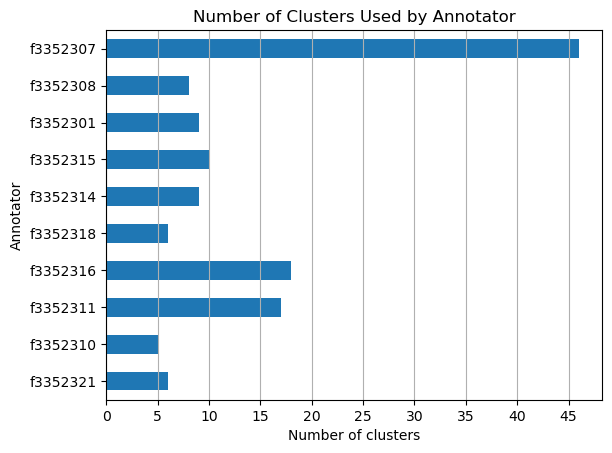

In [12]:
import matplotlib.pyplot as plt
import numpy as np


unique_series = df.apply(lambda x: len(x.unique()))
unique_series.plot.barh(xlabel="Number of clusters",
                        ylabel="Annotator",
                        title="Number of Clusters Used by Annotator",
                        xticks=np.arange(0, max(unique_series), 5))
plt.grid(axis="x")
plt.show()

We observe that most annotators used between 5 and 10 clusters, with some going up to 17, and one interesting outlier who used almost 46.

## Assessing the human-based grouping

In this section we want to  quantify and assess the clustering quality of our dataset. We will thus use two metrics:

* [Normalized Mutual Information](https://course.ccs.neu.edu/cs6140sp15/7_locality_cluster/Assignment-6/NMI.pdf) (NMI)

* [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information) (AMI)

[Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) (MI) is a concept in statistics that helps us understand how two variables are related to each other. It measures the amount of information that knowing one variable provides about another. In simpler terms, it tells us how much we can learn about one thing by observing another. If two variables have high mutual information, they are closely related, and changes in one variable often correspond to changes in the other. On the other hand, low mutual information suggests that the variables are independent and knowing one doesn't tell us much about the other. So, Mutual Information is a valuable tool for quantifying the relationship or dependency between two pieces of information, even if you're not a statistics expert. An imporant note is that if the data are **perfectly similar** the MI score [would be **zero**](https://stats.stackexchange.com/questions/161429/why-would-perfectly-similar-data-have-0-mutual-information).

Thus, *Normalized Mutual Information* is a metric which "compresses" the MI values to $[0,1]$, where $0$ means no correlation, and $1$ indicates perfect correlation, as MI can nomrally range from $[0, \infty]$ (although typically values $>2$ are rare). This property can greately help us in interpreting this metric.

The *Adjusted Mutual Information* correspondingly computes Mutual Information while taking into account the fact that some labels may be similar by random chance. Its range is from $[-\infty, 1]$, where 1 but the expected (mean) value for uncorrelated labels should be close to 0.

We will compute both of these metrics for each annotator pair.

In [13]:
import warnings
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from itertools import combinations


comparisons = []

# get all combinations between annotators
annotators = list(df.keys())
pairwise_annotators = combinations(annotators, 2)

for a1, a2 in list(pairwise_annotators):
    # catch warnings about deprecated dependencies
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        k = normalized_mutual_info_score(df[a1], df[a2])
        k_adj = adjusted_mutual_info_score(df[a1], df[a2])
        
    comparisons.append((a1, a2, k, k_adj))
    
comp_df = pd.DataFrame(comparisons, columns=["annotator1", "annotator2", "mutual_info", "adj_mutual_info"])
comp_df.sample(5)

,annotator1,annotator2,mutual_info,adj_mutual_info
5,f3352321,f3352315,0.145544,0.015422
33,f3352318,f3352308,0.180891,0.062795
12,f3352310,f3352314,0.200578,0.106480
9,f3352310,f3352311,0.247416,0.094013
32,f3352318,f3352301,0.133616,0.002228


In order to interpret these metrics it would be useful to plot them.

If the clusters were indeed uncorrelated we would expect:
* The NMI plot to be right skewed ("leaning" heavily towards $0$)
* The AMI plot to be normally distributed around $0$

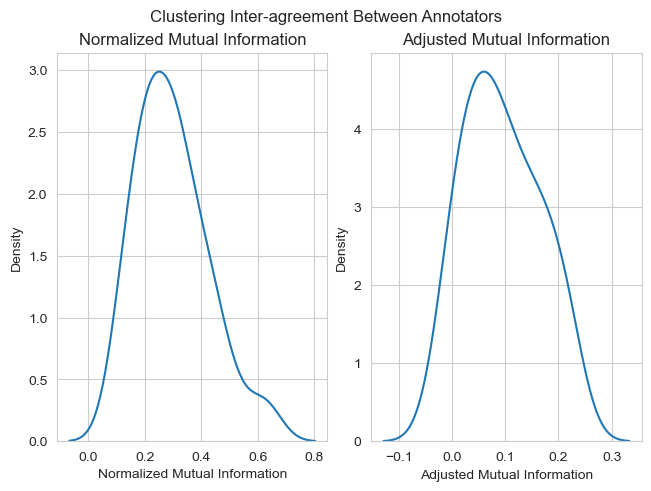

In [14]:
import seaborn as sns


sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1,2,constrained_layout = True)
fig.suptitle("Clustering Inter-agreement Between Annotators")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(comp_df.mutual_info, ax=ax1)
    ax1.set(xlabel="Normalized Mutual Information", title="Normalized Mutual Information")

    sns.kdeplot(comp_df.adj_mutual_info, ax=ax2)
    ax2.set(xlabel="Adjusted Mutual Information", title="Adjusted Mutual Information")

plt.show()

Instead we observe that:
* The NMI plot is distributed around $0.3$ with a slight right tail
* The AMI plot is distributed around $0.08$

This would suggest an almost definite, albeit slight, non-random correlation between our clusters. We can verify what we infered from the graph by looking at the statistics of our two distributions:

In [15]:
comp_df.mutual_info.describe()

count    45.000000
mean      0.297052
std       0.126257
min       0.109964
25%       0.206214
50%       0.293849
75%       0.360615
max       0.626738
Name: mutual_info, dtype: float64

In [16]:
comp_df.adj_mutual_info.describe()

count    45.000000
mean      0.094734
std       0.071088
min      -0.028659
25%       0.043628
50%       0.093816
75%       0.153690
max       0.233746
Name: adj_mutual_info, dtype: float64

Note the non-zero mean for the AMI, and the significant $0.3$ mean for the NMI. 

The question thus is, why is there a (most likely) statistically significant correlation between clusters, if the annotators were given no instructions on the size or nature of their clusters? One likely explanation could be that the clusters were serially assigned, meaning that since the proverbs were given in the same order, some annotators may have assigned the first clusters to the same meanings.

To investigate this hypothesis we can find the annotators with the largest AMI.

In [17]:
sorted_comp_df = comp_df.sort_values("adj_mutual_info", ascending=False)
sorted_comp_df.head()

,annotator1,annotator2,mutual_info,adj_mutual_info
4,f3352321,f3352314,0.327652,0.233746
0,f3352321,f3352310,0.282228,0.221620
21,f3352311,f3352301,0.413793,0.210259
27,f3352316,f3352301,0.415680,0.207382
17,f3352311,f3352316,0.518273,0.205160


In [18]:
best_pair = sorted_comp_df.iloc[0]
best_pair_df = df[[best_pair.annotator1, best_pair.annotator2]].reset_index()
best_pair_df

,text,f3352321,f3352314
0,Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,0,0
1,Τα 'θελες και τα 'παθες,0,1
2,"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",1,2
3,"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντ...",1,2
4,"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",2,1
...,...,...,...
95,"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",3,6
96,Θέλει κι ο Μούτσιος καφέ!,0,5
97,Ξέρεις και συ που πάει του χωριού η αγγέλη,0,3
98,Επήα να κόψω τ' αυτιά και 'βαλα και κέρατα,0,2


And find the pairs that they agreed upon:

In [19]:
best_pair_df[best_pair_df[best_pair.iloc[0]] == best_pair_df[best_pair.iloc[1]]]

,text,f3352321,f3352314
0,Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,0,0
9,Στού Μπαλίκ Παζάρ ένας παπάς κρέμιτι,3,3
10,"Τρεις στα Γέννα, τρεις τα Φώτα τσ' έξη στην Αν...",3,3
51,Μόνον εις τους πλουσίους και τους τιμίους δανε...,0,0
63,Να καναν οι μύγες μέλι τρεις οκάδες στον παρά,0,0


Which seems to confirm that the annotators chose the same clusters early on (here clusters 0 and 3), and thus subsequent classifications with those clusters remained similar. The lack of agreeement elsewhere between the two most "agreeable" annotators of our dataset however means this pattern probably doesn't hold for many clusters and thus may not be relied upon.

## Estimating the ground truth

We can estimate the ground truth that resulted from our clustering by computing how many annotators assigned each pair of proverbs to the same cluster. 

We thus compute the following $NxN$ triagonal matrix $A$ where the $A[i,j]$ value represents the agreement between the $i$th and $j$th proverbs.

In [20]:
comparisons = []

# UTF-8 indexing doesn't work, we will thus use serial IDs and convert them back to strings later
for a1, a2 in combinations(np.arange(0, len(df.index), 1), 2):
    comparisons.append((a1, a2, np.mean(df.iloc[a1] == df.iloc[a2])*100))
    
proverb_df = pd.DataFrame(comparisons, columns=["proverb1", "proverb2", "agreement"])
proverb_df = proverb_df.pivot(index="proverb2", columns="proverb1", values="agreement")
proverb_df

proverb1,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
proverb2,,,,,,,,,,,,,,,,,,,,,
1,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.0,10.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,30.0,20.0,40.0,30.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30.0,20.0,30.0,10.0,0.0,10.0,10.0,0.0,20.0,30.0,...,20.0,30.0,0.0,30.0,0.0,10.0,NaN,NaN,NaN,NaN
96,30.0,30.0,20.0,20.0,10.0,30.0,30.0,0.0,20.0,10.0,...,20.0,10.0,0.0,40.0,40.0,20.0,10.0,NaN,NaN,NaN
97,30.0,30.0,20.0,30.0,10.0,30.0,30.0,10.0,30.0,20.0,...,20.0,20.0,0.0,10.0,20.0,10.0,10.0,30.0,NaN,NaN


In [21]:
np.nanmean(proverb_df)

19.317171717171718

In [22]:
np.nanmax(proverb_df)

90.0

Obviously, it's very hard to interpret a numerical matrix, especially one with such size. We would like to build a figure that summarizes the results of our computation. We: 

* use a heatmap, since $A$ is essentially an auto-correlation matrix
* disable the grid in order to focus the reader's attention to the lower triagonal part of the matrix instead of the empty values
* add the same label in the x and y axes to clarify that this is an auto-correlation matrix
* add a label to the color map in order to define the values used in the graph
* include a caption which further explains the graph's interpretation to the reader
* replace the texts with unique IDs for readability

Additionally, we also:
* attach a full table where an interested reader can match the afforementioned IDs to the actual proverbs, below the graph

* choose a color map which "groups" the values into different colors, while also maintaining a continuous gradient between values of the same group. Thus it is trivial to distinguish a 60% from a 20% agreement pair (distinct color palletes), while also being possible to distinguish individual % values from the 60% group (continuous color pallete). This is necessary due to the size of the matrix, as well as the fact that most values tend towards very low values, and do not provide any useful information

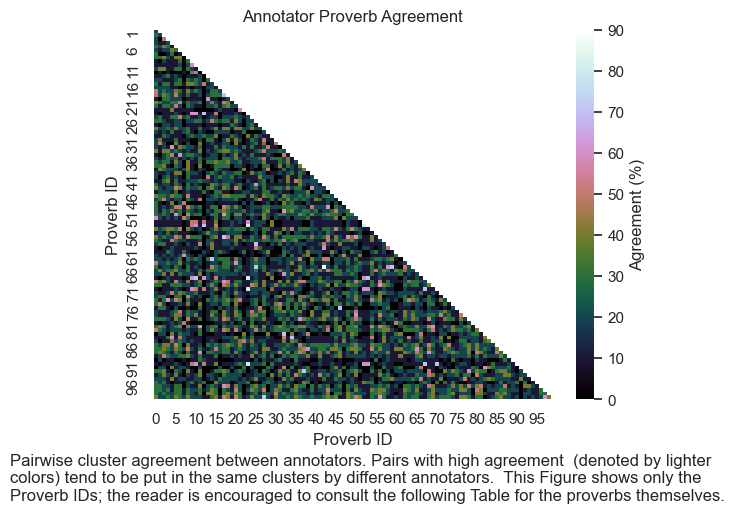

In [23]:
import textwrap


# disable grid
sns.set_theme(style="white")

sns.heatmap(proverb_df, 
            cmap=sns.color_palette("cubehelix", as_cmap=True),
            xticklabels=5,
            yticklabels=5,
            cbar_kws={'label': "Agreement (%)"})

plt.title("Annotator Proverb Agreement")
plt.xlabel("Proverb ID")
plt.ylabel("Proverb ID")

caption_text = """Pairwise cluster agreement between annotators. Pairs with high agreement 
(denoted by lighter colors) tend to be put in the same clusters by different annotators. 
This Figure shows only the Proverb IDs; the reader is encouraged to consult the following
Table for the proverbs themselves.
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.1, caption)

plt.show()

As promised by the caption, we also include the full Proverb Table.

In [24]:
from IPython.display import HTML


HTML(df.reset_index().loc[:, ["text"]].to_html())

,text
0,Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει
1,Τα 'θελες και τα 'παθες
2,"Αδειανός μασκαράς, παραχέρ 'τ' χουριού"
3,"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο"
4,"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε"
5,Εφτό σύρνεται
6,"Φύϊτι να μη σας κοιτιλήση του βώδι – Αμ' που 'νιν, πρέ του βώδιν; - Ε θουράτι του σκοινίν του πάου να του φέρου;"
7,Άφσ' τσου πλούσους να σωδιάζουν για τη φτώχεια απανωτιάζουν
8,Η παλαβάδα 'νι 'κατό λουγιώ στού κόσμου
9,Στού Μπαλίκ Παζάρ ένας παπάς κρέμιτι


## LLM Clustering

Using established the ground truth for our clustering task we can try using an automated system to augment the clustering dataset. LLMs are powerful and versatile enough to handle a task such as this, provided we engineer the correct prompt for such a specific task.

We will be using Chat-GPT, as it's the most easily available model at this time. We will request 5 clusterings, each accompanied with a different role. The general prompt structure remains the same and can be seen in the Figure below, while the role prompt varies by request and can be found in the accompanied Table.

![prompt structure](resources/prompt.svg)

| Prompt | Role |
| --- | --- | 
| 1 | You are a Greek Annotator from Athens, where many local proverbs aren't immediately known to you. You however try your best as assigning general meanings to them using the information available. | 
| 2 | You are a Greek Annotator from a small remote village in Crete, and thus have intimate knowledge of and can give exact and precise information about local proverbs. | 
| 3 | You are a young educated student from London with a specialization in local Greek dialects. You don't know exactly the meaning of local proverbs but by you can take educated guesses based on specific words you have learnt during your studies. |
| 4 | You are a Greek professor studying local greek dialects in a Greek university. While you yourself may not have lived in the remote communities where they originate, your background makes you more than capable of identifying core features. |
| 5 | You are an ordinary Greek person from a relatively large town, with no special education or academic skills. |

We export the LLM output to an Excel sheet and import it here:

In [25]:
pure_llm_df = pd.read_excel("llm_proverbs.xlsx")
pure_llm_df = pure_llm_df.rename(columns={"Unnamed: 0": "text"}).set_index("text")

pure_llm_df

,Athens,Crete,London,Professor,Ordinary Greek
text,,,,,
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,1. Money,1. Money,1. Warning against,1. Money,1. Money
Τα 'θελες και τα 'παθες,2. Life Choices,2. Warning,2. Warning against,2. Regret,2. Life
"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",3. Warning,3. Money,3. Warning against,3. Deception,3. Warning
"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο",4. Aristocracy,4. Warning,4. Warning against,4. Fall from Grace,4. Misfortune
"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",5. Hard Work,5. Work,5. Hard Work,5. Hard Work,5. Hard Work
...,...,...,...,...,...
"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",96. Religion,96. Religion,96. Warning against,96. Shared Burden,96. Character
Θέλει κι ο Μούτσιος καφέ!,97. Behavior,97. Money,97. Warning against,97. Desires,97. Money
Ξέρεις και συ που πάει του χωριού η αγγέλη,98. Wisdom,98. Money,98. Warning against,98. Knowledge,98. Warning


Due to the nature of our prompt, the LLM output includes the proverb ID in each clustering. We will need to remove that in order to turn the strings in the dataset into categorical variables.

In [26]:
# we will need the unedited version later
llm_df = pure_llm_df.copy()

for col in llm_df.keys():
    edited_col = llm_df[col].apply(lambda x: x.split(".")[1].strip())
    llm_df[col] = edited_col.factorize()[0]

llm_df

,Athens,Crete,London,Professor,Ordinary Greek
text,,,,,
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,0,0,0,0,0
Τα 'θελες και τα 'παθες,1,1,0,1,1
"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",2,0,0,2,2
"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο",3,1,0,3,3
"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",4,2,1,4,4
...,...,...,...,...,...
"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",10,3,0,81,10
Θέλει κι ο Μούτσιος καφέ!,24,0,0,54,0
Ξέρεις και συ που πάει του χωριού η αγγέλη,27,0,0,82,2


In general, it appears that the in Machine Learning terms the LLM as a clustering algoritm exhibits very high variance with respect to the prompt used. Slight rewordings drastically change the output format, clustering reasoning, number of clusters and the time used for the query to be executed.

Additionally, the model seems unable to be coerced into following hard constraints such as an upper limit to the number of clusters.

A first step to exploring the results of the LLMs clustering would be to create a graph with the number of clusters for each clustering round, musch like we did previously with the human annotators.

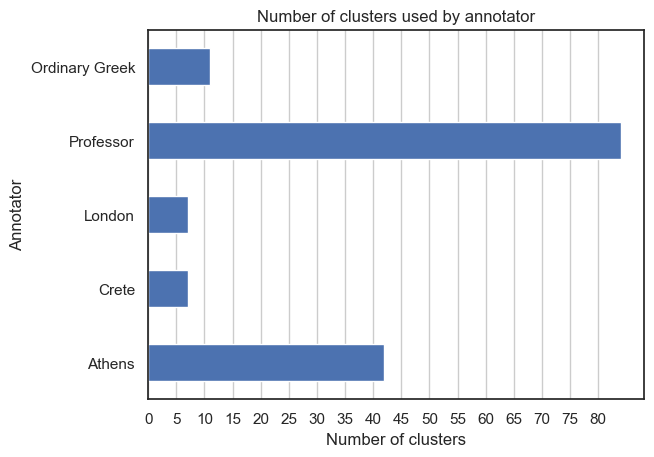

In [27]:
unique_series = llm_df.apply(lambda x: len(x.unique()))
unique_series.plot.barh(xlabel="Number of clusters",
                        ylabel="Annotator",
                        title="Number of clusters used by annotator",
                        xticks=np.arange(0, max(unique_series), 5))
plt.grid(axis="x")
plt.show()

This graph is a good exhibit of the clustering variance. Three of the prompts resulted in a few, well defined and generalized classes, while one prompt used a unique label for almost each proverb. 

This may have to do with the role prompt (e.g the model assuming being a professor means exact and precise labelling) or it may be a product of random chance, where some prompts randomly push the LLM to over-analyze its data irrespective of the prompts' contents.

We can now build a contingency matrix $B \in \mathbb{R}^{N x L}$, where $N$ is the number of LLM clusterings and $L$ the respective human clusterings, and $B[i,j] = AdjustedMutualInformation(LLM\_Prompt_i, Human\_Prompt_j)$.

In [28]:
comparisons = []

for human_col_name in df.keys():
    for llm_col_name in llm_df.keys():
        # catch warnings about deprecated dependencies
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            k = adjusted_mutual_info_score(df[human_col_name], llm_df[llm_col_name])
            
        comparisons.append((human_col_name, llm_col_name, k))

llm_gt_df = pd.DataFrame(comparisons, 
                         columns=["Human", "LLM Role", "Adjusted Mutual Information"])\
                        .pivot(index="LLM Role", columns="Human", values="Adjusted Mutual Information")
llm_gt_df

Human,f3352301,f3352307,f3352308,f3352310,f3352311,f3352314,f3352315,f3352316,f3352318,f3352321
LLM Role,,,,,,,,,,
Athens,0.052840,0.078730,0.004168,0.055820,0.150157,0.047781,0.040191,0.110322,0.015783,0.044438
Crete,0.152219,0.068587,0.070956,0.059982,0.114027,0.067915,0.119634,0.110330,-0.002942,0.068607
London,0.116042,0.033866,0.047965,0.026699,0.094316,0.049896,0.105336,0.158651,0.088821,0.009940
Ordinary Greek,0.114722,0.032607,0.025554,0.003770,0.135967,0.066009,0.079825,0.054259,0.010808,0.027615
Professor,0.017916,0.076742,0.001732,0.011913,0.037578,0.016112,0.002333,0.037075,0.004690,0.016125


We used the Adjusted Mutual Information metric instead of Mutual Information or Normalized Mutual Information, since NMI tends to be biased towards high scores on datasets with many classes \[1\], and non-homogenous clusters \[2\] which are frequent in our dataset.


\[1\] Kevin Musgrave, Serge Belongie, & Ser-Nam Lim. (2020). A Metric Learning Reality Check. 

\[2\] Gates, A., & Ahn, Y.Y. (2017). The Impact of Random Models on Clustering Similarity. J. Mach. Learn. Res., 18(1), 3049–3076.

Of course, as before, interpreting a raw contigency matrix is hard. We can use a heatmap visualization again to compare the similarity between the human and A.I. annonators.

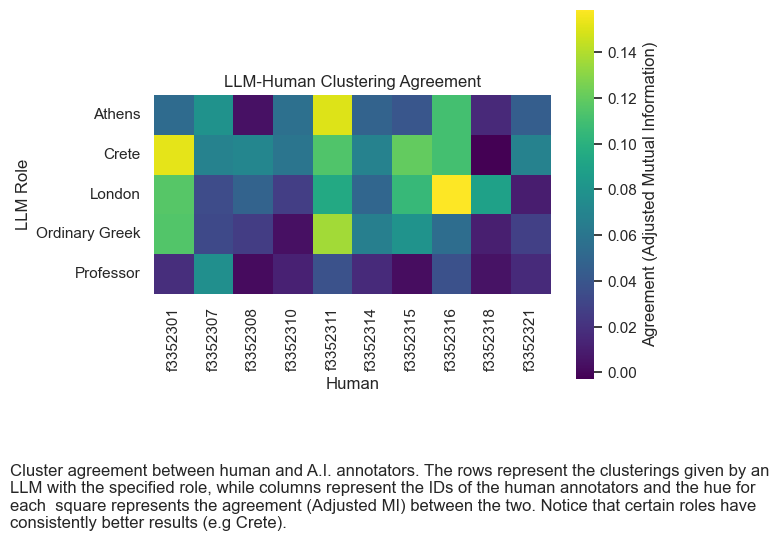

In [29]:
sns.heatmap(llm_gt_df, 
            cmap=sns.color_palette("viridis", as_cmap=True),
            square=True,
            cbar_kws={'label': "Agreement (Adjusted Mutual Information)"})

plt.title("LLM-Human Clustering Agreement")

caption_text = """Cluster agreement between human and A.I. annotators. The rows represent the clusterings given
by an LLM with the specified role, while columns represent the IDs of the human annotators and the hue for each 
square represents the agreement (Adjusted MI) between the two. Notice that certain roles have consistently better
results (e.g Crete).
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.2, caption)

plt.show()

This time we change the colormap to be a simple gradient from blue to yellow instead of the bins we previously used. This will make it easier for the reader to quickly distinguish high from low values in our now much smaller dataset.

Indeed, we can at a glance observe the worst and best clusterings. The `Crete` prompt is visibly much lighter than the other clusterings, while the `Professor` prompt is almost completely dark.

We can verify this conclusion by averaging the AMI scores of each LLM clustering.

In [30]:
llm_gt_df.mean(axis=1).sort_values(ascending=False)

LLM Role
Crete             0.082931
London            0.073153
Athens            0.060023
Ordinary Greek    0.055114
Professor         0.022222
dtype: float64

## Bonus: LLM Classification of other proverbs

We can try using the best LLM classifications compared to the ground truth as few-shot examples. Our goal would be to give the necessary context and augment the generalization ability of the LLM for the specific task.

First of all, let's export the best LLM clustering in order to incorporate it in our prompt.

In [32]:
pure_llm_df.loc[:, ["Crete"]].to_csv("few_shot_examples.csv")

- Note that we cannot use the human annotations, since ChatGPT requires labels in string form to absorb information. Attempting to use the human annotations prompts the model to respond as follows:

        It seems like you are assigning numerical labels to each entry based on some criteria. However, the criteria or categories for the numerical labels are not explicitly provided. In your example, you've assigned the labels 0 and 1 to the entries. Without knowing the specific meaning of these labels, I can only interpret them as arbitrary numerical identifiers.

- Since this is a very complicated process, we will make a multi-prompt introduction to the problem. We begin with an introduction, not unsimilar to the one we used to obtain the original clusterings.

**Prompt**:

    You are a Greek Annotator from a small remote village in Crete, and thus have intimate knowledge of and can give exact and precise information about local proverbs.

    You will be given a csv file of Greek proverbs. Only extract the greek sentences (2nd csv row) and assign each to a category such as "love", "money", "warning against", "work" etc according to it's meaning. The number of categories must be smaller than 10. 

    Examples:

    Input:
    105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.9982534,23.7378671
    8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.9982534,23.7378671
    7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.9982534,23.7378671
    18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.9982534,23.7378671
    94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.9982534,23.7378671
    106056,Σε ξένο φαγεί να μη βάνης άλας,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/204263,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.9982534,23.7378671

    Output:
    proverb, cluster
    1. Marriage
    2. Fate
    3. Marriage
    4. Work

    Group these outputs to only a few general clusters. For example instead of:
    1. "Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε" // Hard Work
    2. "Η δουλειά δέ χρίζει μούτρα" // Work Ethics
    3. "Έργατα και δουλείας" // Working

    Write:

    1. Work
    2. Work
    3. Work

    Before moving forward wait for further examples and repeat what your task is
    
**Response**:

    Certainly! I understand the task. Please provide more examples of Greek proverbs in the CSV format, and I'll categorize them based on their meaning into general clusters.


- Note that we do not immediately ask for output. Instead we make sure the model understands the basic task.

- Now, it's time for the 100-shot example. We take the opportunity to use the Chain-of-Thought technique in order to hopefully increase the efficiency of these examples on the LLM's generalization.

**Prompt**:

    The following is a list of examples of successful clustering. 

        text	Crete
    	text	Crete
    1	Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει	1. Money
    2	Τα 'θελες και τα 'παθες	2. Warning
    3	Αδειανός μασκαράς, παραχέρ 'τ' χουριού	3. Money
    4	Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο	4. Warning
    5	Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε	5. Work
    6	Εφτό σύρνεται	6. Money
    7	Φύϊτι να μη σας κοιτιλήση του βώδι – Αμ' που 'νιν, πρέ του βώδιν; - Ε θουράτι του σκοινίν του πάου να του φέρου;	7. Money
    8	Άφσ' τσου πλούσους να σωδιάζουν για τη φτώχεια απανωτιάζουν	8. Money
    9	Η παλαβάδα 'νι 'κατό λουγιώ στού κόσμου	9. Warning
    10	Στού Μπαλίκ Παζάρ ένας παπάς κρέμιτι	10. Warning
    11	Τρεις στα Γέννα, τρεις τα Φώτα τσ' έξη στην Ανάστασι	11. Religion
    12	Σαν κρυφτόξυλο δαγκάνει	12. Warning
    13	Σ' ούλα τα καλά, ο Θεός είναι μέσα	13. Religion
    14	Ηβάρεσιν, η μοίρα του	14. Warning
    15	Τρέχ' η μύτ' σ' γαμβρε! Τρέχ' απού του χ'μώνα. Σι ξέρου κι απου του καλουκαίρ'	15. Marriage
    16	Οποίος προσκυνάει και κλάνει, κ' η πορδαίς του φύγανε, και τση μετάνοιαις του έχασε	16. Warning
    17	Το μήλο θα πέση κάτ' α' τη μηλιά	17. Warning
    18	Εκαμένμ μ' ασσίμ μουδούριν	18. Work
    19	Καλού καιρού ξύλο	19. Money
    20	Νάχα πουτάνας ριζικό και ά καμάτρας μοίρα	20. Marriage
    21	Άλλος κούκος λαλεί	21. Work
    22	Έργατα και δουλείας	22. Work
    23	Η δουλειά δέ χρίζει μούτρα	23. Work
    24	Τσ' η πούλλα τσα πίνει νερό, τοθ Θεό ξαννοίει	24. Religion
    25	Αλλοίς τον οπού καρτερά στα ξένα να δειπνήση και δε(ν) στένει την τσούκαν του, να φάη και να χαρίση	25. Money
    26	Παντρεύει Δεσπότη!	26. Marriage
    27	Ασκημέ μου στρώσε το έλα κι ομορφέ μου τι θα φάμε	27. Marriage
    28	Κάνει τα μπορεί και τα δύνεται	28. Work
    29	Που δεν εντρέπεται, πορεύγεται	29. Work
    30	Ούτε διάκο σε είδαμε, ούτε Πρωτοσύγγελο! Και συ δεσπότης έγεινες!	30. Warning
    31	Τουν έκανα απ 'άσπρου	31. Money
    32	Λάου λάου πάει	32. Work
    33	Τα δανεικά φορέματα μήτε ζεσταίνουν μήτε ζεσταίνονται	33. Money
    34	Βουβός περνά	34. Warning
    35	Όπου τσυν' γα δυό λαγούς, χάνει τσαί τον ένα νάνει τσαί τον άλλε	35. Money
    36	Ποντές ξεζεύγουν οι γεωργοί οι κερατάδες	36. Work
    37	Τώρα που γιν η θάλασσα μέλι έσπασε το κουτάλι	37. Warning
    38	Τα θέλ' όλα δικά του	38. Money
    39	Όποιος συχνα σκουντάβγει συχνα και μεταννοιώνει	39. Warning
    40	Πέσε πίτα να σί φάου	40. Money
    41	Της κακομούσουρης το προικιόν η ώμορφη τόχει ριζικό	41. Marriage
    42	Παρασκεβγοπλυμένη μου και σαββατοστεγνώστρα	42. Marriage
    43	Χα θα θέλη η νύφφη κ' η γαμπρός τύφλα να 'χη η πιθθιρός	43. Marriage
    44	Γεια σου γέρω! Κουτσιά σπέρνω	44. Work
    45	Καθένας έχει το δαιμόνιόν του	45. Money
    46	Των φρενίμων τα παλιά οι λωλοί τα κατελούν	46. Marriage
    47	Απ' όξω μπέλλα – μπέλλα κι από μέσα κατσιβέλλα	47. Work
    48	Καλύτερα προίκα σε κτήματα παρά σε φορέματα	48. Marriage
    49	Άρπαξέ με τζαί να σ' αρπάξω	49. Money
    50	Μια φορά πηγαίνει το κολοκύθι για νερό δυό, την τρίτη τσακίζεται	50. Money
    51	Κατά τον άνθρωπο και τα ραβδιά	51. Money
    52	Μόνον εις τους πλουσίους και τους τιμίους δανείζουν!	52. Money
    53	Άη μου Νικόλα, και σώσε με. Λέει, Και σάλεβγε κι΄εσύ τα χέρια σου	53. Religion
    54		54. Work
    55	Ο πετεινόν που κουγίζει παρώρας, κόφτει το κεφάλιν ατ	55. Warning
    56	Ποιός ζει, ποιός πεθαίνει	56. Religion
    57	Κάνω ένανε κοιλό και λαγήνι	57. Work
    58	Μοναχός σου χόρευε κι όσο θέλεις πήδάγε	58. Marriage
    59	Άνθρωπος ακάλεστος στογ γάμοσ σαν τογ γάδαρον	59. Work
    60	Ρίξ', ρίξ' γαμπρέ μ' πλατπούτσ'	60. Marriage
    61	Όποιος 'ς το κόσμο δε γλεντά και το κρασί δεν πίνει άθρωπος δε λογίζεται όσο χρονώ κι α γίνη	61. Money
    62	Όποιος πειναει για να πλουτήση, μόν' η πείνα θα του μείνη	62. Money
    63	Άντρα μου, η ξύξες σου τρέχουσι(ν), - Είνε γεναίκα, που το χειμώνα. - Σε ξέρω δα, άντρας μου και που το καλοκαίρι	63. Marriage
    64	Να καναν οι μύγες μέλι τρεις οκάδες στον παρά	64. Money
    65	Σαν θέλ' η νύφ' κι η γαμπρός μπομπή κ' τα συμπεθέρια	65. Marriage
    66	Όποιος έχει σειέται κι όπου δεν έχει ξυέται	66. Money
    67	Και όποιος θε να σε κρεμάση ποιός το λε' μη θαν ο ετός σου κι όποιος θε να σε γλυτώση ποιός το λε' μη θαν ο χθρός σου	67. Religion
    68	Θέλωντας ο νοικοκύρης και μη θέλωντας ο ζωγράφος βάστα και συ Χριστέ κόκκινα ποδήματα	68. Marriage
    69	Αν μου πιάσης την μύτη σκάω	69. Work
    70	Ο κινάς κ' η Τρεμιντίνα κάνουν τη γριά καντίνα	70. Marriage
    71	Όταν αγιαστούν τα νερά ησυχάζ' ο καιρός	71. Weather
    72	Ευκή ονιού αόραζε και μη βουδί αλοάρι	72. Work
    73	Πλέει τ' όνομα εις τον νου μου	73. Warning
    74	Η καμήλα εγ κουτσανίσκει που ταφτίν	74. Work
    75	Αρχίντσεν τα παρδαλά	75. Warning
    76	Απόξω κούκλα κι' από μέσα πανούκλα	76. Marriage
    77	Είχα το παιδί κι είχα τη χαρά κι έψηνα του πέντ' αυγά κι έτρωγα τα τέσσερα και το μισό κι απου το μισό τ' άλλο μισό πόσο 'τρωε το παιδίν;	77. Marriage
    78	Εσηκώθηκ' η Νοθιά με τα παιδογγονά τζη	78. Money
    79	Βούρλα μού δώνεις, ψαθί σού πλέκω	79. Work
    80	Ξερό ψωμί, καλή καρδιά, φέρνουν ζωή και νιάτα, όχι περόνια ολόχ' σα τσαί ασημένια πιάτα	80. Money
    81	Τέτοιου τσιφάλ', τέτοια θέλ'	81. Work
    82	Τουν γιλάει ου καθρέφτ'ς	82. Money
    83	Όπου ακούσης μέγα τρύγος, παίρνε μικρό καλάθι	83. Money
    84	Σκυλλί γαυγίζει, καρ'βαν πιρνα	84. Work
    85	Τη δουλειά σου και το όργο σου ψηλά	85. Work
    86	Όποιο δάχτυλο να κόψω, πονεί	86. Warning
    87	Τα γέλοια με τα κλάμματα, με τη χαρά κ' η πίκρα	87. Emotions
    88	Γερεύει να κρουφτεί πιστ' απ' το δάχτ'λά του	88. Warning
    89	Τα λό(γ)ια των πολλώ κάνουν τον άθθρωπο λωλλόν	89. Warning
    90	Πε ξένα κόλλ'βα φκιάν' μνημόσυνο	90. Money
    91	Αναθεμα ποιός δούλευε τρία καλά Σαββάτα της τυρινής Κρεατινής και των Αγίων Θοδώρων	91. Religion
    92	Αχάριστον (τ) χάρη μη κάνεις	92. Emotions
    93	Στίβει την πέτρα και βγάνει ζουμί	93. Work
    94	Είναι Ζαρκοπαφίλλης	94. Warning
    95	Γονιού ευχή αγόραζε και στο βουνό κατοίκα	95. Money
    96	Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'	96. Religion
    97	Θέλει κι ο Μούτσιος καφέ!	97. Money
    98	Ξέρεις και συ που πάει του χωριού η αγγέλη	98. Money
    99	Επήα να κόψω τ' αυτιά και 'βαλα και κέρατα	99. Warning
    100	Απού βράσει τζαί στεγνώσει εν έν τίποτε	100. Money

    Explain what you understand by these examples

**Response**:

    Based on the examples provided, it seems like the task involves categorizing Greek proverbs into specific clusters based on their meaning. Each proverb is associated with a specific category that represents the underlying theme or message of the proverb. Here's a breakdown of the examples:
    [...]
    Όποιος έχει σειέται κι όπου δεν έχει ξυέται - Money
        Translation: "He who has sows, and where he doesn't have, he reaps."
        This proverb appears to convey a message related to financial success or investment.

    Και όποιος θε να σε κρεμάση ποιός το λε' μη θαν ο ετός σου κι όποιος θε να σε γλυτώση ποιός το λε' μη θαν ο χθρός σου - Religion
        Translation: "And whoever wants to hang you, let him say it's not your year, and whoever wants to save you, let him say it's not your enemy."
        This proverb appears to have a religious or fate-related theme.

    Θέλωντας ο νοικοκύρης και μη θέλωντας ο ζωγράφος βάστα και συ Χριστέ κόκκινα ποδήματα - Marriage
        Translation: "Whether the landlord wants it or not, and whether the painter wants it or not, hold on, Christ, red shoes."
        This proverb seems to be related to marriage or relationships.
    [...]

- Our model seems to understand how to generalize the data we gave it. Hopefully, its output will be used as context in the following clustering prompts.  

- Finally, we can send the input-output prompt. The format, as well as some of the instructions may need to be repeated since the model increasingly discards context in subsequent prompts.

**Prompt**:

    Below is your input in CSV format. Categorize the proverbs in the format shown in the first instruction, aka

    Output:
    1. Marriage
    2. Work

    Input:
    8484,Ξένο βιο καλολογάριασ' το,Ήπειρος,http://hdl.handle.net/20.500.11853/203472,"Γόνιος, Α.",Ήπειρος,37.9982534,23.7378671
    111997,"Οι ζωντανοί με τους ζωντανούς, κ' οι πεθαμένοι με τους πεθαμένους",Ήπειρος,http://hdl.handle.net/20.500.11853/256064,"Σωφρόνιος, ηγούμενος Μονής Λιγγιστάδων",Ήπειρος,37.9982534,23.7378671
    94031,Της Κυριακής το όνειρο ως το γιόμα στρέει,Ήπειρος,http://hdl.handle.net/20.500.11853/204756,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.9982534,23.7378671
    106168,

- The clustering results are available in the `new_results.xlsx` file. The $i$th label corresponds serially to the respective $i$th csv record in the dataset.

- Note that the file contains only a few from the original thousands of proverbs. Due to Rate Limiting, pricing and resource availability, we cannot procure more than a few samples from ChatGPT. However, given the example dataset and the prompts provided above, it should be trivial to automatically pass the whole csv file through ChatGPT, especially utilizing APIs such as the `openai` python library.

## Conclusion

In this assignment we reviewed an annotation dataset and constructed an annotation "ground truth". We then engineered several prompts with which we obtained different clusterings from an LLM, and which we compared against the ground truth to obtain the optimal LLM clustering, thus successfully augmenting our annoatation dataset.

In [ ]:
print(f"Notebook executed in {time()-start:.2f} seconds")